<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# Merlin ETL, training and inference demo on the e-Commerce behavior data

## Overview

In this tutorial, we will be using the [eCommerce behavior data from multi category store](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store) from [REES46 Marketing Platform](https://rees46.com/) as our dataset. This tutorial is built upon the NVIDIA RecSys 2020 [tutorial](https://recsys.acm.org/recsys20/tutorials/). 

This jupyter notebook provides the code to preprocess the dataset and generate the train, validation and test sets for the remainder of the tutorial. We define our own goal and filter the dataset accordingly.

For our tutorial, we decided that our goal is to predict if a user purchased an item:

-  Positive: User purchased an item
-  Negative: User added an item to the cart, but did not purchase it (in the same session)    


We split the dataset into train, validation and test set by the timestamp:
- Training: October 2019 - February 2020
- Validation: March 2020
-  Test: April 2020

We remove AddToCart Events from a session, if in the same session the same item was purchased.

## Table of Contents
1. [Data](#1)
1. [ETL with NVTabular](#2)
1. [Training with HugeCTR](#3)
1. [HugeCTR inference](#4)


<a id="1"></a>
## 1. Data
First, we download and unzip the raw data.

Note: the dataset is ~11GB and will take a while to download.

In [ ]:
%%bash
export HOME=$PWD
pip install gdown --user
~/.local/bin/gdown  https://drive.google.com/uc?id=1-Rov9fFtGJqb7_ePc6qH-Rhzxn0cIcKB
~/.local/bin/gdown  https://drive.google.com/uc?id=1-Rov9fFtGJqb7_ePc6qH-Rhzxn0cIcKB
~/.local/bin/gdown  https://drive.google.com/uc?id=1zr_RXpGvOWN2PrWI6itWL8HnRsCpyqz8
~/.local/bin/gdown  https://drive.google.com/uc?id=1g5WoIgLe05UMdREbxAjh0bEFgVCjA1UL
~/.local/bin/gdown  https://drive.google.com/uc?id=1qZIwMbMgMmgDC5EoMdJ8aI9lQPsWA3-P
~/.local/bin/gdown  https://drive.google.com/uc?id=1x5ohrrZNhWQN4Q-zww0RmXOwctKHH9PT

In [2]:
import glob  

list_files = glob.glob('*.csv.gz')
list_files

['2019-Dec.csv.gz',
 '2020-Apr.csv.gz',
 '2020-Mar.csv.gz',
 '2020-Feb.csv.gz',
 '2020-Jan.csv.gz']

### Data extraction and initial preprocessing

We extract a few relevant columns from the raw datasets and parse date columns into several atomic colunns (day, month...).

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def process_files(file):
    df_tmp = pd.read_csv(file, compression='gzip')
    df_tmp['session_purchase'] =  df_tmp['user_session'] + '_' + df_tmp['product_id'].astype(str)
    df_purchase = df_tmp[df_tmp['event_type']=='purchase']
    df_cart = df_tmp[df_tmp['event_type']=='cart']
    df_purchase = df_purchase[df_purchase['session_purchase'].isin(df_cart['session_purchase'])]
    df_cart = df_cart[~(df_cart['session_purchase'].isin(df_purchase['session_purchase']))]
    df_cart['target'] = 0
    df_purchase['target'] = 1
    df = pd.concat([df_cart, df_purchase])
    df = df.drop('category_id', axis=1)
    df = df.drop('session_purchase', axis=1)
    df[['cat_0', 'cat_1', 'cat_2', 'cat_3']] = df['category_code'].str.split("\.", n = 3, expand = True).fillna('NA')
    df['brand'] = df['brand'].fillna('NA')
    df = df.drop('category_code', axis=1)
    df['timestamp'] = pd.to_datetime(df['event_time'].str.replace(' UTC', ''))
    df['ts_hour'] = df['timestamp'].dt.hour
    df['ts_minute'] = df['timestamp'].dt.minute
    df['ts_weekday'] = df['timestamp'].dt.weekday
    df['ts_day'] = df['timestamp'].dt.day
    df['ts_month'] = df['timestamp'].dt.month
    df['ts_year'] = df['timestamp'].dt.year
    df.to_csv('./dataset/' + file.replace('.gz', ''), index=False)
    
!mkdir ./dataset
for file in tqdm(list_files):
    print(file)
    process_files(file)

  0%|                                                                                   | 0/5 [00:00<?, ?it/s]

2019-Dec.csv.gz


 20%|██████████████▊                                                           | 1/5 [04:16<17:05, 256.45s/it]

2020-Apr.csv.gz


 40%|█████████████████████████████▌                                            | 2/5 [08:34<12:51, 257.29s/it]

2020-Mar.csv.gz


 60%|████████████████████████████████████████████▍                             | 3/5 [12:02<07:49, 234.67s/it]

2020-Feb.csv.gz


 80%|███████████████████████████████████████████████████████████▏              | 4/5 [15:30<03:44, 224.22s/it]

2020-Jan.csv.gz


100%|██████████████████████████████████████████████████████████████████████████| 5/5 [19:05<00:00, 229.04s/it]


### Prepare train/validation/test data

Next, we split the data into train, validation and test sets. We will be using 3 months for training, 1 month for validation and 1 month for testing.

In [4]:
lp = []
list_files = glob.glob('./dataset/*.csv')

In [5]:
!ls -l ./dataset/*.csv

-rw-r--r-- 1 root dip 479323170 Nov 16 22:47 ./dataset/2019-Dec.csv
-rw-r--r-- 1 root dip 455992639 Nov 16 22:51 ./dataset/2020-Apr.csv
-rw-r--r-- 1 root dip 453967664 Nov 16 22:58 ./dataset/2020-Feb.csv
-rw-r--r-- 1 root dip 375205173 Nov 16 23:02 ./dataset/2020-Jan.csv
-rw-r--r-- 1 root dip 403896607 Nov 16 22:55 ./dataset/2020-Mar.csv


In [6]:
for file in list_files:
    lp.append(pd.read_csv(file))

In [7]:
df = pd.concat(lp)
df.shape

(13184044, 19)

In [8]:
df_test = df[df['ts_month']==4]
df_valid = df[df['ts_month']==3]
df_train = df[(df['ts_month']!=3)&(df['ts_month']!=4)]

In [9]:
df_train.shape, df_valid.shape, df_test.shape

((7949839, 19), (2461719, 19), (2772486, 19))

In [10]:
!mkdir -p ./data
df_train.to_parquet('./data/train.parquet', index=False)
df_valid.to_parquet('./data/valid.parquet', index=False)
df_test.to_parquet('./data/test.parquet', index=False)

In [11]:
df_train.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,cat_0,cat_1,cat_2,cat_3,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year
0,2020-02-01 00:00:18 UTC,cart,100065078,xiaomi,568.61,526615078,5f0aab9f-f92e-4eff-b0d2-fcec5f553f01,0,construction,tools,light,NaN,2020-02-01 00:00:18,0,0,5,1,2,2020
1,2020-02-01 00:00:18 UTC,cart,5701246,NaN,24.43,563902689,76cc9152-8a9f-43e9-b98a-ee484510f379,0,electronics,video,tv,NaN,2020-02-01 00:00:18,0,0,5,1,2,2020
2,2020-02-01 00:00:31 UTC,cart,14701533,NaN,154.42,520953435,5f1c7752-cf92-41fc-9a16-e8897a90eee8,0,electronics,video,projector,NaN,2020-02-01 00:00:31,0,0,5,1,2,2020
3,2020-02-01 00:00:40 UTC,cart,1004855,xiaomi,123.30,519236281,e512f514-dc7f-4fc9-9042-e3955989d395,0,construction,tools,light,NaN,2020-02-01 00:00:40,0,0,5,1,2,2020
4,2020-02-01 00:00:47 UTC,cart,1005100,samsung,140.28,550305600,bd7a37b6-420d-4575-8852-ac825aff39b5,0,construction,tools,light,NaN,2020-02-01 00:00:47,0,0,5,1,2,2020


<a id="2"></a>
## 2. Preprocessing with NVTabular

Next, we will use NVTabular for preprocessing and engineering more features. 

But first, we need to import the necessary libraries and initialize a Dask GPU cluster for computation.

### Initialize Dask GPU cluster


In [12]:
# Standard Libraries
import os
from time import time
import re
import shutil
import glob
import warnings

# External Dependencies
import numpy as np
import pandas as pd
import cupy as cp
import cudf
import dask_cudf
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
from dask.utils import parse_bytes
from dask.delayed import delayed
import rmm

# NVTabular
import nvtabular as nvt
import nvtabular.ops as ops
from nvtabular.io import Shuffle
from nvtabular.utils import _pynvml_mem_size, device_mem_size

print(nvt.__version__)

0.7.1


In [13]:
# define some information about where to get our data
BASE_DIR = "./nvtabular_temp"
!rm -r $BASE_DIR && mkdir $BASE_DIR
input_path = './dataset'
dask_workdir = os.path.join(BASE_DIR, "workdir")
output_path = os.path.join(BASE_DIR, "output")
stats_path = os.path.join(BASE_DIR, "stats")

rm: cannot remove './nvtabular_temp': No such file or directory


This example was tested on a DGX server with 8 GPUs. If you have less GPUs, modify the `NUM_GPUS` variable accordingly.

In [14]:
NUM_GPUS = [0,1,2,3,4,5,6,7]
#NUM_GPUS = [0]

# Dask dashboard
dashboard_port = "8787"

# Deploy a Single-Machine Multi-GPU Cluster
protocol = "tcp"             # "tcp" or "ucx"
visible_devices = ",".join([str(n) for n in NUM_GPUS])  # Delect devices to place workers
device_limit_frac = 0.5      # Spill GPU-Worker memory to host at this limit.
device_pool_frac = 0.6
part_mem_frac = 0.05

# Use total device size to calculate args.device_limit_frac
device_size = device_mem_size(kind="total")
device_limit = int(device_limit_frac * device_size)
device_pool_size = int(device_pool_frac * device_size)
part_size = int(part_mem_frac * device_size)

# Check if any device memory is already occupied
"""
for dev in visible_devices.split(","):
    fmem = _pynvml_mem_size(kind="free", index=int(dev))
    used = (device_size - fmem) / 1e9
    if used > 1.0:
        warnings.warn(f"BEWARE - {used} GB is already occupied on device {int(dev)}!")
"""

cluster = None               # (Optional) Specify existing scheduler port
if cluster is None:
    cluster = LocalCUDACluster(
        protocol = protocol,
        n_workers=len(visible_devices.split(",")),
        CUDA_VISIBLE_DEVICES = visible_devices,
        device_memory_limit = device_limit,
        local_directory=dask_workdir,
        dashboard_address=":" + dashboard_port,
    )

# Create the distributed client
client = Client(cluster)
client

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


Connection method: Cluster object,Cluster type: LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 503.81 GiB
Comm: tcp://127.0.0.1:42281,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 503.81 GiB
Comm: tcp://127.0.0.1:45134,Total threads: 1
Dashboard: http://127.0.0.1:45519/status,Memory: 62.98 GiB
Nanny: tcp://127.0.0.1:40585,


In [15]:
!nvidia-smi

Tue Nov 16 23:03:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   41C    P0    44W / 300W |    508MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   

In [16]:
# Initialize RMM pool on ALL workers
def _rmm_pool():
    rmm.reinitialize(
        # RMM may require the pool size to be a multiple of 256.
        pool_allocator=True,
        initial_pool_size=(device_pool_size // 256) * 256, # Use default size
    )
    
client.run(_rmm_pool)

{'tcp://127.0.0.1:33468': None,
 'tcp://127.0.0.1:38052': None,
 'tcp://127.0.0.1:38832': None,
 'tcp://127.0.0.1:41440': None,
 'tcp://127.0.0.1:43583': None,
 'tcp://127.0.0.1:45134': None,
 'tcp://127.0.0.1:45442': None,
 'tcp://127.0.0.1:46068': None}

### Define NVTabular dataset

In [17]:
train_paths = glob.glob('./data/train.parquet')
valid_paths = glob.glob('./data/valid.parquet')
test_paths = glob.glob('./data/test.parquet')

train_dataset = nvt.Dataset(train_paths, engine='parquet', part_mem_fraction=0.15)
valid_dataset = nvt.Dataset(valid_paths, engine='parquet', part_mem_fraction=0.15)
test_dataset = nvt.Dataset(test_paths, engine='parquet', part_mem_fraction=0.15)

In [18]:
train_dataset.to_ddf().head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,cat_0,cat_1,cat_2,cat_3,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year
0,2020-02-01 00:00:18 UTC,cart,100065078,xiaomi,568.61,526615078,5f0aab9f-f92e-4eff-b0d2-fcec5f553f01,0,construction,tools,light,<NA>,2020-02-01 00:00:18,0,0,5,1,2,2020
1,2020-02-01 00:00:18 UTC,cart,5701246,<NA>,24.43,563902689,76cc9152-8a9f-43e9-b98a-ee484510f379,0,electronics,video,tv,<NA>,2020-02-01 00:00:18,0,0,5,1,2,2020
2,2020-02-01 00:00:31 UTC,cart,14701533,<NA>,154.42,520953435,5f1c7752-cf92-41fc-9a16-e8897a90eee8,0,electronics,video,projector,<NA>,2020-02-01 00:00:31,0,0,5,1,2,2020
3,2020-02-01 00:00:40 UTC,cart,1004855,xiaomi,123.30,519236281,e512f514-dc7f-4fc9-9042-e3955989d395,0,construction,tools,light,<NA>,2020-02-01 00:00:40,0,0,5,1,2,2020
4,2020-02-01 00:00:47 UTC,cart,1005100,samsung,140.28,550305600,bd7a37b6-420d-4575-8852-ac825aff39b5,0,construction,tools,light,<NA>,2020-02-01 00:00:47,0,0,5,1,2,2020


In [19]:
len(train_dataset.to_ddf().columns)

19

In [20]:
train_dataset.to_ddf().columns

Index(['event_time', 'event_type', 'product_id', 'brand', 'price', 'user_id',
       'user_session', 'target', 'cat_0', 'cat_1', 'cat_2', 'cat_3',
       'timestamp', 'ts_hour', 'ts_minute', 'ts_weekday', 'ts_day', 'ts_month',
       'ts_year'],
      dtype='object')

In [21]:
len(train_dataset.to_ddf())

7949839

### Preprocessing and feature engineering

In this notebook we will explore a few feature engineering technique with NVTabular:

- Creating cross features, e.g. `user_id` and `'brand`
- Target encoding

The engineered features will then be preprocessed into a form suitable for machine learning model:

- Fill missing values
- Encoding categorical features into integer values
- Normalization of numeric features

In [22]:
from nvtabular.ops import LambdaOp

# cross features
def user_id_cross_maker(col, gdf):
    return col.astype(str) + '_' + gdf['user_id'].astype(str)

user_id_cross_features = (
    nvt.ColumnGroup(['product_id', 'brand', 'ts_hour', 'ts_minute']) >>
    LambdaOp(user_id_cross_maker, dependency=['user_id']) >> 
    nvt.ops.Rename(postfix = '_user_id_cross')
)


def user_id_brand_cross_maker(col, gdf):
    return col.astype(str) + '_' + gdf['user_id'].astype(str) + '_' + gdf['brand'].astype(str)

user_id_brand_cross_features = (
    nvt.ColumnGroup(['ts_hour', 'ts_weekday', 'cat_0', 'cat_1', 'cat_2']) >>
    LambdaOp(user_id_brand_cross_maker, dependency=['user_id', 'brand']) >> 
    nvt.ops.Rename(postfix = '_user_id_brand_cross')
)

target_encode = (
    ['brand', 'user_id', 'product_id', 'cat_2', ['ts_weekday', 'ts_day']] >>
    nvt.ops.TargetEncoding(
        nvt.ColumnGroup('target'),
        kfold=5,
        p_smooth=20,
        out_dtype="float32",
        )
)

cat_feats = (user_id_brand_cross_features + user_id_cross_features) >> nvt.ops.Categorify()
cont_feats =  ['price', 'ts_weekday', 'ts_day', 'ts_month'] >> nvt.ops.FillMissing() >>  nvt.ops.Normalize()
cont_feats += target_encode >> nvt.ops.Rename(postfix = '_TE')

In [23]:
output = cat_feats + cont_feats + 'target'
proc = nvt.Workflow(output)

/nvtabular/nvtabular/workflow/workflow.py:89: UserWarning: A global dask.distributed client has been detected, but the single-threaded scheduler will be used for execution. Please use the `client` argument to initialize a `Workflow` object with distributed-execution enabled.
  warnings.warn(


### Visualize workflow as a DAG


In [ ]:
!apt install -y graphviz

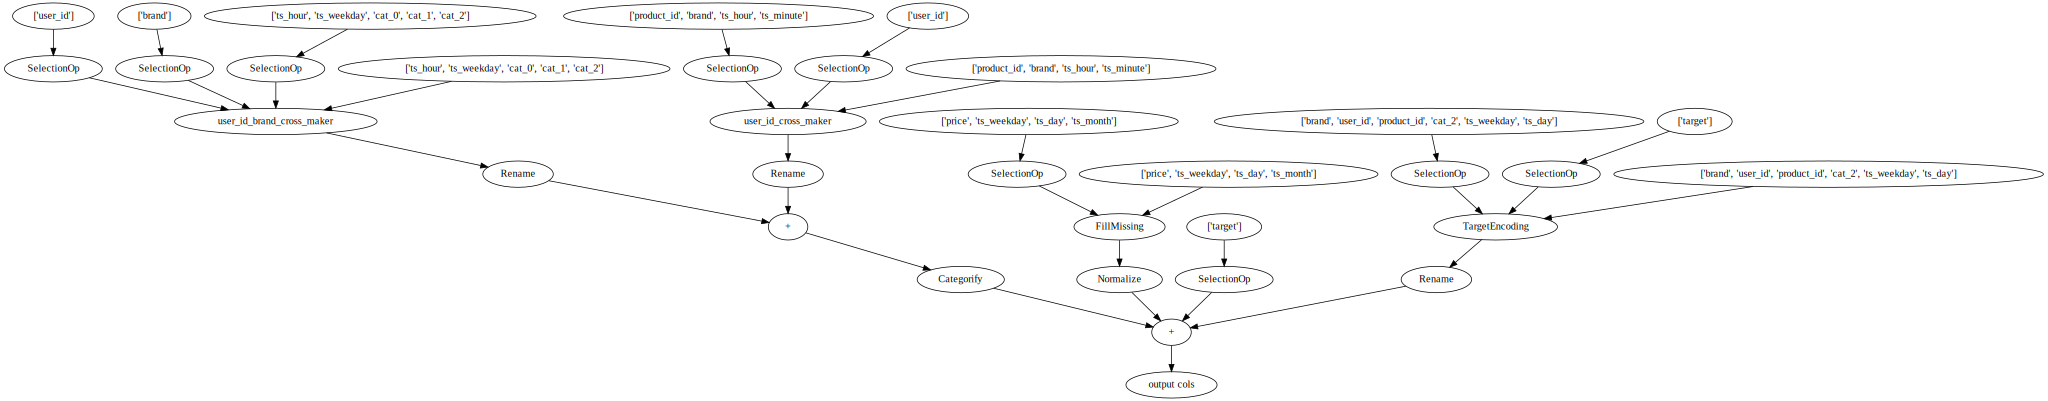

In [25]:
output.graph

### Executing the workflow

After having defined the workflow, calling the `fit()` method will start the actual computation to record the required statistics from the training data.

In [26]:
%%time
time_preproc_start = time()
proc.fit(train_dataset)
time_preproc = time()-time_preproc_start

/usr/local/lib/python3.8/dist-packages/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (112) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


CPU times: user 13.3 s, sys: 10.1 s, total: 23.4 s
Wall time: 26.8 s


In [27]:
cat_feats.output_columns.names

['ts_hour_user_id_brand_cross',
 'ts_weekday_user_id_brand_cross',
 'cat_0_user_id_brand_cross',
 'cat_1_user_id_brand_cross',
 'cat_2_user_id_brand_cross',
 'product_id_user_id_cross',
 'brand_user_id_cross',
 'ts_hour_user_id_cross',
 'ts_minute_user_id_cross']

In [28]:
output.output_columns.names

['ts_hour_user_id_brand_cross',
 'ts_weekday_user_id_brand_cross',
 'cat_0_user_id_brand_cross',
 'cat_1_user_id_brand_cross',
 'cat_2_user_id_brand_cross',
 'product_id_user_id_cross',
 'brand_user_id_cross',
 'ts_hour_user_id_cross',
 'ts_minute_user_id_cross',
 'price',
 'ts_weekday',
 'ts_day',
 'ts_month',
 'TE_brand_target_TE',
 'TE_user_id_target_TE',
 'TE_product_id_target_TE',
 'TE_cat_2_target_TE',
 'TE_ts_weekday_ts_day_target_TE',
 'target']

In [29]:
CAT_FEATS = ['ts_hour_user_id_brand_cross',
 'ts_weekday_user_id_brand_cross',
 'cat_0_user_id_brand_cross',
 'cat_1_user_id_brand_cross',
 'cat_2_user_id_brand_cross',
 'product_id_user_id_cross',
 'brand_user_id_cross',
 'ts_hour_user_id_cross',
 'ts_minute_user_id_cross',]

CON_FEATS = ['price',
 'ts_weekday',
 'ts_day',
 'ts_month',
 'TE_brand_target_TE',
 'TE_user_id_target_TE',
 'TE_product_id_target_TE',
 'TE_cat_2_target_TE',
 'TE_ts_weekday_ts_day_target_TE']

dict_dtypes = {}
for col in CAT_FEATS:
    dict_dtypes[col] = np.int64
for col in CON_FEATS:
    dict_dtypes[col] = np.float32

dict_dtypes['target'] = np.float32

Next, we call the `transform()` method to transform the datasets.

In [30]:
output_train_dir = os.path.join(output_path, 'train/')
output_valid_dir = os.path.join(output_path, 'valid/')
output_test_dir = os.path.join(output_path, 'test/')
! rm -rf $output_train_dir && mkdir -p $output_train_dir
! rm -rf $output_valid_dir && mkdir -p $output_valid_dir
! rm -rf $output_test_dir && mkdir -p $output_test_dir

In [31]:
%%time

time_preproc_start = time()
proc.transform(train_dataset).to_parquet(output_path=output_train_dir, dtypes=dict_dtypes,
                                         shuffle=nvt.io.Shuffle.PER_PARTITION,
                                         cats=CAT_FEATS,
                                         conts=CON_FEATS,
                                         labels=['target'])
time_preproc += time()-time_preproc_start

/nvtabular/nvtabular/io/dask.py:375: UserWarning: A global dask.distributed client has been detected, but the single-threaded scheduler will be used for this write operation. Please use the `client` argument to initialize a `Dataset` and/or `Workflow` object with distributed-execution enabled.
  warnings.warn(


CPU times: user 1.6 s, sys: 3.29 s, total: 4.89 s
Wall time: 5.79 s


In [32]:
!ls -l $output_train_dir

total 366131
-rw-r--r-- 1 root dip        47 Nov 16 23:04 _file_list.txt
-rw-r--r-- 1 root dip     18283 Nov 16 23:04 _metadata
-rw-r--r-- 1 root dip      1045 Nov 16 23:04 _metadata.json
-rw-r--r-- 1 root dip 706364298 Nov 16 23:04 part_0.parquet
-rw-r--r-- 1 root dip      7975 Nov 16 23:04 schema.pbtxt


In [33]:
%%time

time_preproc_start = time()
proc.transform(valid_dataset).to_parquet(output_path=output_valid_dir, dtypes=dict_dtypes,
                                         shuffle=nvt.io.Shuffle.PER_PARTITION,
                                         cats=CAT_FEATS,
                                         conts=CON_FEATS,
                                         labels=['target'])
time_preproc += time()-time_preproc_start

CPU times: user 1.06 s, sys: 1.57 s, total: 2.63 s
Wall time: 2.83 s


In [34]:
!ls -l $output_valid_dir

total 100979
-rw-r--r-- 1 root dip       47 Nov 16 23:04 _file_list.txt
-rw-r--r-- 1 root dip     8983 Nov 16 23:04 _metadata
-rw-r--r-- 1 root dip     1045 Nov 16 23:04 _metadata.json
-rw-r--r-- 1 root dip 92826604 Nov 16 23:04 part_0.parquet
-rw-r--r-- 1 root dip     7975 Nov 16 23:04 schema.pbtxt


In [35]:
%%time

time_preproc_start = time()
proc.transform(test_dataset).to_parquet(output_path=output_test_dir, dtypes=dict_dtypes,
                                         shuffle=nvt.io.Shuffle.PER_PARTITION,
                                         cats=CAT_FEATS,
                                         conts=CON_FEATS,
                                         labels=['target'])
time_preproc += time()-time_preproc_start

CPU times: user 1.05 s, sys: 1.64 s, total: 2.69 s
Wall time: 2.75 s


In [36]:
time_preproc

38.198790550231934

### Verify the preprocessed data

Let's quickly read the data back and verify that all fields have the expected format.

In [37]:
!ls $output_train_dir

_file_list.txt	_metadata  _metadata.json  part_0.parquet  schema.pbtxt


In [38]:
nvtdata = pd.read_parquet(output_train_dir+'/part_0.parquet')
nvtdata.head()

,ts_hour_user_id_brand_cross,ts_weekday_user_id_brand_cross,cat_0_user_id_brand_cross,cat_1_user_id_brand_cross,cat_2_user_id_brand_cross,product_id_user_id_cross,brand_user_id_cross,ts_hour_user_id_cross,ts_minute_user_id_cross,price,ts_weekday,ts_day,ts_month,TE_brand_target_TE,TE_user_id_target_TE,TE_product_id_target_TE,TE_cat_2_target_TE,TE_ts_weekday_ts_day_target_TE,target
0,817883,908980,0,0,0,1085846,855303,144463,5417827,-0.725652,-0.502085,0.235441,1.314784,0.199788,0.325234,0.227236,-1.284867,0.387063,0.0
1,4152058,2732403,1210052,712779,0,1360101,954962,731363,2230166,-0.836849,-0.007929,-0.802043,-0.864342,0.355313,0.266837,0.255486,-1.285741,0.420646,0.0
2,3204608,274365,30730,31144,25505,29457,32720,3039842,3062261,-0.184922,-0.007929,1.618752,-0.864342,0.466206,0.237990,0.414308,0.459563,0.239809,0.0
3,0,0,0,0,0,3464677,0,2467278,2493129,-0.841169,-0.007929,0.465993,-0.666240,-1.285569,0.390281,0.318047,-1.288352,0.376334,0.0
4,2665639,66327,19261,19397,16204,2497109,16447,2620458,2349810,3.510283,0.486228,0.581269,-0.666240,0.446405,0.533477,0.492186,0.459563,0.388496,0.0


In [39]:
!ls $output_valid_dir

_file_list.txt	_metadata  _metadata.json  part_0.parquet  schema.pbtxt


In [40]:
nvtdata_valid = pd.read_parquet(output_valid_dir+'/part_0.parquet')
nvtdata_valid.head()

,ts_hour_user_id_brand_cross,ts_weekday_user_id_brand_cross,cat_0_user_id_brand_cross,cat_1_user_id_brand_cross,cat_2_user_id_brand_cross,product_id_user_id_cross,brand_user_id_cross,ts_hour_user_id_cross,ts_minute_user_id_cross,price,ts_weekday,ts_day,ts_month,TE_brand_target_TE,TE_user_id_target_TE,TE_product_id_target_TE,TE_cat_2_target_TE,TE_ts_weekday_ts_day_target_TE,target
0,0,0,0,0,0,0,0,0,0,1.107537,0.980384,-0.225663,-0.468138,0.372078,0.390281,0.427259,0.390176,0.353950,0.0
1,0,0,0,0,0,0,0,0,0,-0.840005,0.980384,-0.225663,-0.468138,0.364968,0.390281,0.320797,-1.284867,0.352739,0.0
2,0,0,0,0,0,0,0,0,0,-0.327548,-1.490397,-0.802043,-0.468138,0.466705,0.390281,0.498779,0.459734,0.380590,1.0
3,0,0,0,0,0,0,0,0,0,2.291189,-1.490397,-1.608975,-0.468138,0.446405,0.390281,0.303992,0.459563,0.408594,0.0
4,0,0,2677742,1812225,1033276,3759307,2828489,0,0,-0.738273,-0.007929,1.157649,-0.468138,0.277334,0.390281,0.326134,0.257637,0.409076,0.0


In [41]:
sum(nvtdata_valid['ts_hour_user_id_brand_cross']==0)

2359020

In [42]:
len(nvtdata_valid)

2461719

### Getting the embedding size

Next, we need to get the embedding size for the categorical variables. This is an important input for defining the embedding table size to be used by HugeCTR.

In [43]:
embeddings = ops.get_embedding_sizes(proc)
embeddings

{'ts_hour_user_id_brand_cross': (4427037, 512),
 'ts_weekday_user_id_brand_cross': (3961156, 512),
 'cat_0_user_id_brand_cross': (2877223, 512),
 'cat_1_user_id_brand_cross': (2890639, 512),
 'cat_2_user_id_brand_cross': (2159304, 512),
 'product_id_user_id_cross': (4398425, 512),
 'brand_user_id_cross': (3009092, 512),
 'ts_hour_user_id_cross': (3999369, 512),
 'ts_minute_user_id_cross': (5931061, 512)}

In [44]:
print([embeddings[x][0] for x in cat_feats.output_columns.names])

[4427037, 3961156, 2877223, 2890639, 2159304, 4398425, 3009092, 3999369, 5931061]


In [45]:
cat_feats.output_columns.names

['ts_hour_user_id_brand_cross',
 'ts_weekday_user_id_brand_cross',
 'cat_0_user_id_brand_cross',
 'cat_1_user_id_brand_cross',
 'cat_2_user_id_brand_cross',
 'product_id_user_id_cross',
 'brand_user_id_cross',
 'ts_hour_user_id_cross',
 'ts_minute_user_id_cross']

In [46]:
embedding_size_str = "{}".format([embeddings[x][0] for x in cat_feats.output_columns.names])
embedding_size_str

'[4427037, 3961156, 2877223, 2890639, 2159304, 4398425, 3009092, 3999369, 5931061]'

In [47]:
num_con_feates = len(CON_FEATS)
num_con_feates

9

In [48]:
print([embeddings[x][0] for x in cat_feats.output_columns.names])

[4427037, 3961156, 2877223, 2890639, 2159304, 4398425, 3009092, 3999369, 5931061]


Next, we'll shutdown our Dask client from earlier to free up some memory so that we can share it with HugeCTR.

In [49]:
client.shutdown()
cluster.close()

### Preparing the training Python script for HugeCTR

HugeCTR model can be defined by Python API. The below Python script defines a DLRM model and specifies the training resources. 

Several parameters that need to be edited to match this dataset are:

- `slot_size_array`: cadinalities for the categorical variables
- `dense_dim`: number of dense features
- `slot_num`: number of categorical variables


The model graph can be saved into a JSON file by calling `model.graph_to_json`, which will be used for inference afterwards.

In the below we will traing the network using 8 GPUs, and a workspace of 4000MB per GPU. Note that the total embedding size is 33653306*128*4/(1024**3) = 16.432GB

In [1]:
%%writefile hugectr_dlrm_ecommerce.py
import hugectr
from mpi4py import MPI
solver = hugectr.CreateSolver(max_eval_batches = 2720,
                              batchsize_eval = 16384,
                              batchsize = 16384,
                              lr = 0.1,
                              warmup_steps = 8000,
                              decay_start = 48000,
                              decay_steps = 24000,
                              vvgpu = [[0,1,2,3,4,5,6,7]],
                              repeat_dataset = True,
                              i64_input_key = True)
reader = hugectr.DataReaderParams(data_reader_type = hugectr.DataReaderType_t.Parquet,
                                  source = ["./nvtabular_temp/output/train/_file_list.txt"],
                                  eval_source = "./nvtabular_temp/output/valid/_file_list.txt",
                                  check_type = hugectr.Check_t.Non,
                                  slot_size_array = [4427037, 3961156, 2877223, 2890639, 2159304, 4398425, 3009092, 3999369, 5931061])
optimizer = hugectr.CreateOptimizer(optimizer_type = hugectr.Optimizer_t.SGD,
                                    update_type = hugectr.Update_t.Local,
                                    atomic_update = True)
model = hugectr.Model(solver, reader, optimizer)
model.add(hugectr.Input(label_dim = 1, label_name = "label",
                        dense_dim = 9, dense_name = "dense",
                        data_reader_sparse_param_array = 
                        [hugectr.DataReaderSparseParam("data1", 1, True, 9)]))
model.add(hugectr.SparseEmbedding(embedding_type = hugectr.Embedding_t.DistributedSlotSparseEmbeddingHash,
                            workspace_size_per_gpu_in_mb = 4000,
                            embedding_vec_size = 128,
                            combiner = 'sum',
                            sparse_embedding_name = "sparse_embedding1",
                            bottom_name = "data1",
                            optimizer = optimizer))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.InnerProduct,
                            bottom_names = ["dense"],
                            top_names = ["fc1"],
                            num_output=512))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.ReLU,
                            bottom_names = ["fc1"],
                            top_names = ["relu1"]))                           
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.InnerProduct,
                            bottom_names = ["relu1"],
                            top_names = ["fc2"],
                            num_output=256))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.ReLU,
                            bottom_names = ["fc2"],
                            top_names = ["relu2"]))                            
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.InnerProduct,
                            bottom_names = ["relu2"],
                            top_names = ["fc3"],
                            num_output=128))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.ReLU,
                            bottom_names = ["fc3"],
                            top_names = ["relu3"]))                              
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.Interaction,
                            bottom_names = ["relu3","sparse_embedding1"],
                            top_names = ["interaction1"]))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.InnerProduct,
                            bottom_names = ["interaction1"],
                            top_names = ["fc4"],
                            num_output=1024))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.ReLU,
                            bottom_names = ["fc4"],
                            top_names = ["relu4"]))                              
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.InnerProduct,
                            bottom_names = ["relu4"],
                            top_names = ["fc5"],
                            num_output=1024))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.ReLU,
                            bottom_names = ["fc5"],
                            top_names = ["relu5"]))                              
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.InnerProduct,
                            bottom_names = ["relu5"],
                            top_names = ["fc6"],
                            num_output=512))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.ReLU,
                            bottom_names = ["fc6"],
                            top_names = ["relu6"]))                               
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.InnerProduct,
                            bottom_names = ["relu6"],
                            top_names = ["fc7"],
                            num_output=256))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.ReLU,
                            bottom_names = ["fc7"],
                            top_names = ["relu7"]))                                                                              
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.InnerProduct,
                            bottom_names = ["relu7"],
                            top_names = ["fc8"],
                            num_output=1))                                                                                           
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.BinaryCrossEntropyLoss,
                            bottom_names = ["fc8", "label"],
                            top_names = ["loss"]))
model.compile()
model.summary()
model.graph_to_json(graph_config_file = "dlrm_ecommerce.json")
model.fit(max_iter = 12000, display = 1000, eval_interval = 3000, snapshot = 10000, snapshot_prefix = "./")

Overwriting hugectr_dlrm_ecommerce.py


<a id="3"></a>
## 3. HugeCTR training

Now we are ready to train a DLRM model with HugeCTR.



In [2]:
!python3 hugectr_dlrm_ecommerce.py

HugeCTR Version: 3.2
====================================================Model Init=====================================================
[HUGECTR][23:17:45][INFO][RANK0]: Global seed is 1985961998
[HUGECTR][23:17:45][INFO][RANK0]: Device to NUMA mapping:
  GPU 0 ->  node 0
  GPU 1 ->  node 0
  GPU 2 ->  node 0
  GPU 3 ->  node 0
  GPU 4 ->  node 1
  GPU 5 ->  node 1
  GPU 6 ->  node 1
  GPU 7 ->  node 1

[HUGECTR][23:17:54][WARNING][RANK0]: Peer-to-peer access cannot be fully enabled.
[HUGECTR][23:17:54][INFO][RANK0]: Start all2all warmup
[HUGECTR][23:17:54][INFO][RANK0]: End all2all warmup
[HUGECTR][23:17:54][INFO][RANK0]: Using All-reduce algorithm: NCCL
[HUGECTR][23:17:54][INFO][RANK0]: Device 0: Tesla P100-SXM2-16GB
[HUGECTR][23:17:54][INFO][RANK0]: Device 1: Tesla P100-SXM2-16GB
[HUGECTR][23:17:54][INFO][RANK0]: Device 2: Tesla P100-SXM2-16GB
[HUGECTR][23:17:54][INFO][RANK0]: Device 3: Tesla P100-SXM2-16GB
[HUGECTR][23:17:54][INFO][RANK0]: Device 4: Tesla P100-SXM2-16GB
[HUGECTR][

<a id="4"></a>
## 4. HugeCTR inference

In this section, we will read the test dataset, and compute the AUC value. 

We will utilize the saved model graph in JSON format for inference.

### Prepare the inference session

In [3]:
import sys
from hugectr.inference import InferenceParams, CreateInferenceSession
from mpi4py import MPI

In [4]:
# create inference session
inference_params = InferenceParams(model_name = "dlrm",
                              max_batchsize = 4096,
                              hit_rate_threshold = 0.6,
                              dense_model_file = "./_dense_10000.model",
                              sparse_model_files = ["./0_sparse_10000.model"],
                              device_id = 0,
                              use_gpu_embedding_cache = True,
                              cache_size_percentage = 0.2,
                              i64_input_key = True)
inference_session = CreateInferenceSession("dlrm_ecommerce.json", inference_params)

[HUGECTR][23:21:46][INFO][RANK0]: default_emb_vec_value is not specified using default: 0.000000
[HUGECTR][23:21:46][INFO][RANK0]: Created parallel (16 partitions) blank database backend in local memory!
[HUGECTR][23:22:51][INFO][RANK0]: ParallelLocalMemory backend. Table: dlrm#0. Inserted 33653303 / 33653303 pairs.
[HUGECTR][23:22:51][INFO][RANK0]: Cached 0.000000 * 33653303 embeddings in CPU memory database!
[HUGECTR][23:22:52][INFO][RANK0]: Create embedding cache in device 0.
[HUGECTR][23:22:53][INFO][RANK0]: create_refreshspace2
[HUGECTR][23:22:53][INFO][RANK0]: Global seed is 813179416
[HUGECTR][23:22:53][INFO][RANK0]: Device to NUMA mapping:
  GPU 0 ->  node 0

[HUGECTR][23:22:54][WARNING][RANK0]: Peer-to-peer access cannot be fully enabled.
[HUGECTR][23:22:54][INFO][RANK0]: Start all2all warmup
[HUGECTR][23:22:54][INFO][RANK0]: End all2all warmup
[HUGECTR][23:22:54][INFO][RANK0]: Use mixed precision: 0
[HUGECTR][23:22:54][INFO][RANK0]: start create embedding for inference
[HUGEC

### Reading and prepare the data

We first read the NVTabular processed data.

In [5]:
import pandas as pd

nvtdata_test = pd.read_parquet('./nvtabular_temp/output/test/part_0.parquet')
nvtdata_test.head()

,ts_hour_user_id_brand_cross,ts_weekday_user_id_brand_cross,cat_0_user_id_brand_cross,cat_1_user_id_brand_cross,cat_2_user_id_brand_cross,product_id_user_id_cross,brand_user_id_cross,ts_hour_user_id_cross,ts_minute_user_id_cross,price,ts_weekday,ts_day,ts_month,TE_brand_target_TE,TE_user_id_target_TE,TE_product_id_target_TE,TE_cat_2_target_TE,TE_ts_weekday_ts_day_target_TE,target
0,0,0,0,0,0,0,0,0,0,-0.823432,-1.490397,1.272925,-0.270035,-1.287369,0.390281,0.390281,-1.285848,0.445558,0.0
1,0,0,0,0,0,0,0,0,0,-0.627107,-0.996241,0.581269,-0.270035,0.306095,0.390281,0.339375,0.352659,0.396743,0.0
2,0,0,0,0,0,0,0,0,0,-0.299060,-0.996241,1.388201,-0.270035,0.364552,0.390281,0.443069,0.459563,0.433425,0.0
3,0,0,0,0,0,0,0,0,0,-0.037364,1.474540,-0.456215,-0.270035,0.466595,0.390281,0.431157,0.460040,0.407608,1.0
4,0,0,0,0,0,0,0,0,0,-0.704362,-0.502085,-0.917319,-0.270035,0.218853,0.390281,0.274339,-1.285741,0.428683,0.0


In [6]:
con_feats = ['price',
 'ts_weekday',
 'ts_day',
 'ts_month',
 'TE_brand_target_TE',
 'TE_user_id_target_TE',
 'TE_product_id_target_TE',
 'TE_cat_2_target_TE',
 'TE_ts_weekday_ts_day_target_TE']

In [7]:
cat_feats = ['ts_hour_user_id_brand_cross',
 'ts_weekday_user_id_brand_cross',
 'cat_0_user_id_brand_cross',
 'cat_1_user_id_brand_cross',
 'cat_2_user_id_brand_cross',
 'product_id_user_id_cross',
 'brand_user_id_cross',
 'ts_hour_user_id_cross',
 'ts_minute_user_id_cross']

In [8]:
emb_size = [4427037, 3961156, 2877223, 2890639, 2159304, 4398425, 3009092, 3999369, 5931061]

### Converting data to CSR format

HugeCTR expects data in CSR format for inference. One important thing to note is that NVTabular requires categorical variables to occupy different integer ranges. For example, if there are 10 users and 10 items, then the users should be encoded in the 0-9 range, while items should be in the 10-19 range. NVTabular encodes both users and items in the 0-9 ranges.

For this reason, we need to shift the keys of the categorical variable produced by NVTabular to comply with HugeCTR.

In [9]:
import numpy as np
shift = np.insert(np.cumsum(emb_size), 0, 0)[:-1]

In [10]:
cat_data = nvtdata_test[cat_feats].values + shift

In [11]:
dense_data = nvtdata_test[con_feats].values

In [12]:
def infer_batch(inference_session, dense_data_batch, cat_data_batch):
    dense_features = list(dense_data_batch.flatten())
    embedding_columns = list(cat_data_batch.flatten())
    row_ptrs= list(range(0,len(embedding_columns)+1))
    output = inference_session.predict(dense_features, embedding_columns, row_ptrs)
    return output

Now we are ready to carry out inference on the test set.

In [13]:
batch_size = 4096
num_batches = (len(dense_data) // batch_size) + 1
batch_idx = np.array_split(np.arange(len(dense_data)), num_batches)

In [14]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
from tqdm import tqdm

labels = []
for batch_id in tqdm(batch_idx):
    dense_data_batch = dense_data[batch_id]
    cat_data_batch = cat_data[batch_id]
    results = infer_batch(inference_session, dense_data_batch, cat_data_batch)
    labels.extend(results)

In [16]:
len(labels)

2772486

### Computing the test AUC value

In [17]:
ground_truth = nvtdata_test['target'].values

In [18]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ground_truth, labels)

0.5565971533171648

## Conclusion

In this notebook, we have walked you through the process of preprocessing the data, train a DLRM model with HugeCTR, then carrying out inference with the HugeCTR Python interface. Try this workflow on your data and let us know your feedback.

